In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import tqdm

In [10]:
train_df = pd.read_csv("../data/processed/norm_train.csv")
train_X = train_df.drop(['pt_loss'], axis=1)

val_df = pd.read_csv("../data/processed/norm_train.csv")
val_X = val_df.drop(['pt_loss'], axis=1)

In [11]:
class PtLossDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.length = df.shape[0]
        self.params = df.drop('pt_loss', axis=1).values.astype(np.float32)
        self.losses = df['pt_loss'].values.astype(np.float32)
    
    def __getitem__(self, ind: int) -> tuple[np.ndarray, np.ndarray]:
        return self.params[ind, :], self.losses[ind]
    
    def __len__(self) -> int:
        return self.length

In [12]:
train_dataset = PtLossDataset(train_df)
val_dataset = PtLossDataset(val_df)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=32, num_workers=4)

In [13]:
from collections import OrderedDict


class PtLossRegressor(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int = 1,
        num_layers: int = 2,
    ) -> None:
        super().__init__()

        self.layers = self._create_linear_layer(0, input_dim, hidden_dim)
        for i in range(num_layers - 2):
            self.layers += self._create_linear_layer(
                i + 1, hidden_dim, hidden_dim
            )

        self.layers += self._create_linear_layer(
            num_layers - 1, hidden_dim, output_dim, is_last=True
        )
        self.layers = nn.Sequential(OrderedDict(self.layers))

    def _create_linear_layer(
        self, num: int, input_dim: int, output_dim: int, is_last: bool = False
    ) -> list[tuple[str, nn.Module]]:
        layers = [(f"lin_{num}", nn.Linear(input_dim, output_dim))]
        if not is_last:
            layers.append((f"relu_{num}", nn.Tanh()))
        return layers

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)

In [14]:
model = PtLossRegressor(7, 7, 1, num_layers=2).float()
loss_func = nn.MSELoss()

In [15]:
optim = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optim, step_size=100, gamma=0.1)

In [16]:
epochs = 500

tolerance = 1e-8
n_convergence_steps = 5
conv_counter = 0
report_interval = 10

train_loss_history = []
val_loss_history = []
train_metric_history = []
val_metric_history = []

for epoch in tqdm.tqdm(range(epochs)):

    best_params = model.state_dict()
    best_val_metric = 0.0

    model.train()

    train_mean_loss = []
    train_mean_metric = []

    for X, y in train_loader:
        X = X.float()
        y = y.float()
        preds = model(X)
        loss = loss_func(preds[:, 0], y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_mean_loss.append(loss.item())
        train_mean_metric.append(r2_score(y.numpy(), preds[:, 0].detach().numpy()))

    train_mean_loss = np.mean(train_mean_loss)
    train_mean_metric = np.mean(train_mean_metric)

    model.eval()

    val_mean_loss = []
    val_mean_metric = []

    for X, y in val_loader:
        X = X.float()
        y = y.float()
        with torch.set_grad_enabled(False):
            preds = model(X)
            loss = loss_func(preds[:, 0], y)

        val_mean_loss.append(loss.item())
        val_mean_metric.append(r2_score(y.numpy(), preds[:, 0].numpy()))
    
    val_mean_loss = np.mean(val_mean_loss)
    val_mean_metric = np.mean(val_mean_metric)

    if epoch > 0:
        if abs(train_loss_history[-1] - train_mean_loss) < tolerance:
            if conv_counter > n_convergence_steps:
                break
            else:
                conv_counter += 1
        else:
            conv_counter = 0

    train_loss_history.append(train_mean_loss)
    train_metric_history.append(train_mean_metric)
    val_metric_history.append(val_mean_metric)
    val_loss_history.append(val_mean_loss)

    if (epoch + 1) % report_interval == 0:
        print("#" * 50)
        print(f"Epoch: {epoch + 1} / {epochs}")
        print(f"Train loss: {train_loss_history[-1]}")
        print(f"Train r2 score: {train_metric_history[-1]}")
        print(f"Val loss: {val_loss_history[-1]}")
        print(f"Val r2 score: {val_metric_history[-1]}")
        print("#" * 50)
        print()

    if val_mean_metric > best_val_metric:
        best_val_metric = val_mean_metric
        best_params = model.state_dict()

    scheduler.step()

  2%|▏         | 10/500 [00:05<05:08,  1.59it/s]

##################################################
Epoch: 10 / 500
Train loss: 0.007999046444892884
Train r2 score: 0.5534302318481822
Val loss: 0.007833492401987314
Val r2 score: 0.5465477596932224
##################################################



  4%|▍         | 20/500 [00:09<02:35,  3.08it/s]

##################################################
Epoch: 20 / 500
Train loss: 0.006020590155385435
Train r2 score: 0.6827323708830351
Val loss: 0.00617231909185648
Val r2 score: 0.6607522126249896
##################################################



  6%|▌         | 30/500 [00:12<02:19,  3.37it/s]

##################################################
Epoch: 30 / 500
Train loss: 0.00570617888122797
Train r2 score: 0.7041672863508883
Val loss: 0.0057345396699383855
Val r2 score: 0.6881124729360307
##################################################



  8%|▊         | 40/500 [00:15<02:11,  3.49it/s]

##################################################
Epoch: 40 / 500
Train loss: 0.005459549520164728
Train r2 score: 0.7086458387074253
Val loss: 0.005580301713198423
Val r2 score: 0.6981931198557705
##################################################



 10%|█         | 50/500 [00:18<02:07,  3.52it/s]

##################################################
Epoch: 50 / 500
Train loss: 0.005413682046346366
Train r2 score: 0.7118984219659168
Val loss: 0.005480030127801001
Val r2 score: 0.706114732058211
##################################################



 12%|█▏        | 60/500 [00:21<02:08,  3.43it/s]

##################################################
Epoch: 60 / 500
Train loss: 0.00532341128680855
Train r2 score: 0.726807795471474
Val loss: 0.005402220650576055
Val r2 score: 0.7110866564890524
##################################################



 14%|█▍        | 70/500 [00:24<02:04,  3.46it/s]

##################################################
Epoch: 70 / 500
Train loss: 0.005255467002280056
Train r2 score: 0.7293444333578023
Val loss: 0.005347994551993906
Val r2 score: 0.7140735614834907
##################################################



 16%|█▌        | 80/500 [00:27<01:59,  3.52it/s]

##################################################
Epoch: 80 / 500
Train loss: 0.005196102731861174
Train r2 score: 0.7326790382636241
Val loss: 0.005295315054245293
Val r2 score: 0.7192642296922445
##################################################



 18%|█▊        | 90/500 [00:30<02:17,  2.99it/s]

##################################################
Epoch: 90 / 500
Train loss: 0.005294693559408188
Train r2 score: 0.71894610215308
Val loss: 0.00524304430000484
Val r2 score: 0.7227154024736114
##################################################



 20%|██        | 100/500 [00:33<01:51,  3.60it/s]

##################################################
Epoch: 100 / 500
Train loss: 0.005180771928280592
Train r2 score: 0.7311759574032695
Val loss: 0.0052012742450460794
Val r2 score: 0.7246173103318273
##################################################



 22%|██▏       | 110/500 [00:36<01:44,  3.75it/s]

##################################################
Epoch: 110 / 500
Train loss: 0.005145906936377287
Train r2 score: 0.7348564770758571
Val loss: 0.005188317946158349
Val r2 score: 0.7260343652437594
##################################################



 24%|██▍       | 120/500 [00:39<01:46,  3.55it/s]

##################################################
Epoch: 120 / 500
Train loss: 0.0050413550389930605
Train r2 score: 0.7300321102387091
Val loss: 0.005180555153638125
Val r2 score: 0.7266451386458412
##################################################



 26%|██▌       | 130/500 [00:41<01:42,  3.60it/s]

##################################################
Epoch: 130 / 500
Train loss: 0.00508514410816133
Train r2 score: 0.7348371203673355
Val loss: 0.005175002464093268
Val r2 score: 0.7271430673298852
##################################################



 28%|██▊       | 140/500 [00:44<01:45,  3.41it/s]

##################################################
Epoch: 140 / 500
Train loss: 0.005029909131117165
Train r2 score: 0.7471374423986387
Val loss: 0.005167071032337845
Val r2 score: 0.7276862587391798
##################################################



 30%|███       | 150/500 [00:47<01:38,  3.56it/s]

##################################################
Epoch: 150 / 500
Train loss: 0.005057739038020373
Train r2 score: 0.7286161995036319
Val loss: 0.00515888609457761
Val r2 score: 0.7283099351236306
##################################################



 32%|███▏      | 160/500 [00:50<01:32,  3.67it/s]

##################################################
Epoch: 160 / 500
Train loss: 0.0050014556129463015
Train r2 score: 0.7360158216129534
Val loss: 0.005151223284192383
Val r2 score: 0.7290236713714481
##################################################



 34%|███▍      | 170/500 [00:53<01:31,  3.61it/s]

##################################################
Epoch: 170 / 500
Train loss: 0.00516234643291682
Train r2 score: 0.736843337261985
Val loss: 0.0051444316562265155
Val r2 score: 0.7291746633114196
##################################################



 36%|███▌      | 180/500 [00:55<01:33,  3.43it/s]

##################################################
Epoch: 180 / 500
Train loss: 0.005006977659650147
Train r2 score: 0.730786062645954
Val loss: 0.005134232663549483
Val r2 score: 0.7296755227349336
##################################################



 38%|███▊      | 190/500 [00:59<01:29,  3.45it/s]

##################################################
Epoch: 190 / 500
Train loss: 0.0049808580498211085
Train r2 score: 0.74616627513235
Val loss: 0.0051248491741716865
Val r2 score: 0.7307557518045458
##################################################



 40%|████      | 200/500 [01:01<01:24,  3.56it/s]

##################################################
Epoch: 200 / 500
Train loss: 0.005024828077293933
Train r2 score: 0.7348708600794813
Val loss: 0.005116739002987742
Val r2 score: 0.7319978355624915
##################################################



 42%|████▏     | 210/500 [01:04<01:25,  3.41it/s]

##################################################
Epoch: 210 / 500
Train loss: 0.004969415361993015
Train r2 score: 0.735846824629868
Val loss: 0.005113960970193148
Val r2 score: 0.7319465319942268
##################################################



 44%|████▍     | 220/500 [01:07<01:22,  3.41it/s]

##################################################
Epoch: 220 / 500
Train loss: 0.00505689287558198
Train r2 score: 0.7422836287586553
Val loss: 0.0051125469803810115
Val r2 score: 0.7319787577073741
##################################################



 46%|████▌     | 230/500 [01:10<01:17,  3.49it/s]

##################################################
Epoch: 230 / 500
Train loss: 0.004966073385439813
Train r2 score: 0.7412847738656354
Val loss: 0.0051111888978630305
Val r2 score: 0.7320305351722302
##################################################



 48%|████▊     | 240/500 [01:13<01:09,  3.74it/s]

##################################################
Epoch: 240 / 500
Train loss: 0.005012766639702022
Train r2 score: 0.7510034513818513
Val loss: 0.005109892869368196
Val r2 score: 0.7320840180788166
##################################################



 50%|█████     | 250/500 [01:16<01:12,  3.46it/s]

##################################################
Epoch: 250 / 500
Train loss: 0.005008130632340908
Train r2 score: 0.7471203954328538
Val loss: 0.005108470348641276
Val r2 score: 0.7321745278074109
##################################################



 52%|█████▏    | 260/500 [01:18<01:06,  3.60it/s]

##################################################
Epoch: 260 / 500
Train loss: 0.005004311604425311
Train r2 score: 0.7442808486123141
Val loss: 0.005107254642061889
Val r2 score: 0.7322835513359803
##################################################



 54%|█████▍    | 270/500 [01:21<01:02,  3.69it/s]

##################################################
Epoch: 270 / 500
Train loss: 0.005089563205838203
Train r2 score: 0.725599414264311
Val loss: 0.005105899693444371
Val r2 score: 0.7323628843148831
##################################################



 56%|█████▌    | 280/500 [01:24<01:00,  3.67it/s]

##################################################
Epoch: 280 / 500
Train loss: 0.005039048856124282
Train r2 score: 0.7400263329410172
Val loss: 0.005104681113734842
Val r2 score: 0.7324815120200509
##################################################



 58%|█████▊    | 290/500 [01:27<01:10,  2.98it/s]

##################################################
Epoch: 290 / 500
Train loss: 0.00499850207939744
Train r2 score: 0.7423268106405198
Val loss: 0.0051036308845505115
Val r2 score: 0.7325183773859031
##################################################



 60%|██████    | 300/500 [01:32<01:22,  2.43it/s]

##################################################
Epoch: 300 / 500
Train loss: 0.00502014777623117
Train r2 score: 0.7401232909775319
Val loss: 0.0051019284036010505
Val r2 score: 0.7326063794624568
##################################################



 62%|██████▏   | 310/500 [01:35<01:03,  3.00it/s]

##################################################
Epoch: 310 / 500
Train loss: 0.004988901689648629
Train r2 score: 0.7449566981506568
Val loss: 0.005101829008199274
Val r2 score: 0.7325976564487275
##################################################



 64%|██████▍   | 320/500 [01:38<00:53,  3.36it/s]

##################################################
Epoch: 320 / 500
Train loss: 0.0050453832698985936
Train r2 score: 0.7391083852150361
Val loss: 0.005101727233268321
Val r2 score: 0.7326043647676274
##################################################



 66%|██████▌   | 330/500 [01:42<00:58,  2.89it/s]

##################################################
Epoch: 330 / 500
Train loss: 0.004999142051674426
Train r2 score: 0.7468928239591789
Val loss: 0.005101572736166417
Val r2 score: 0.7326170299332984
##################################################



 68%|██████▊   | 340/500 [01:45<00:50,  3.15it/s]

##################################################
Epoch: 340 / 500
Train loss: 0.005078189191408455
Train r2 score: 0.7427772192865654
Val loss: 0.005101454295217991
Val r2 score: 0.732620581970534
##################################################



 70%|███████   | 350/500 [01:48<00:45,  3.28it/s]

##################################################
Epoch: 350 / 500
Train loss: 0.005051066316664219
Train r2 score: 0.7427730110217874
Val loss: 0.005101325297728181
Val r2 score: 0.7326329161977282
##################################################



 72%|███████▏  | 360/500 [01:52<00:49,  2.83it/s]

##################################################
Epoch: 360 / 500
Train loss: 0.005025590052828193
Train r2 score: 0.7472694638185462
Val loss: 0.0051012117601931094
Val r2 score: 0.7326407099582427
##################################################



 74%|███████▍  | 370/500 [01:55<00:39,  3.31it/s]

##################################################
Epoch: 370 / 500
Train loss: 0.0050555293262004855
Train r2 score: 0.7389533248245109
Val loss: 0.005101115605793893
Val r2 score: 0.7326470639628191
##################################################



 76%|███████▌  | 380/500 [01:58<00:34,  3.43it/s]

##################################################
Epoch: 380 / 500
Train loss: 0.005051313955336809
Train r2 score: 0.7403973729497961
Val loss: 0.005101031172089278
Val r2 score: 0.7326522333714174
##################################################



 78%|███████▊  | 390/500 [02:01<00:31,  3.47it/s]

##################################################
Epoch: 390 / 500
Train loss: 0.00495705857872963
Train r2 score: 0.747832622455249
Val loss: 0.005100904549472034
Val r2 score: 0.7326534808153439
##################################################



 80%|████████  | 400/500 [02:04<00:28,  3.54it/s]

##################################################
Epoch: 400 / 500
Train loss: 0.00503211144823581
Train r2 score: 0.7406869962296945
Val loss: 0.005100828623399139
Val r2 score: 0.7326646913070737
##################################################



 82%|████████▏ | 410/500 [02:07<00:28,  3.15it/s]

##################################################
Epoch: 410 / 500
Train loss: 0.0049635737901553515
Train r2 score: 0.7511276723905825
Val loss: 0.005100818518549204
Val r2 score: 0.7326659567468211
##################################################



 84%|████████▍ | 420/500 [02:10<00:25,  3.09it/s]

##################################################
Epoch: 420 / 500
Train loss: 0.00537192470394075
Train r2 score: 0.7379876812463
Val loss: 0.005100807314738632
Val r2 score: 0.7326663259627634
##################################################



 86%|████████▌ | 430/500 [02:13<00:20,  3.42it/s]

##################################################
Epoch: 430 / 500
Train loss: 0.005152708366513253
Train r2 score: 0.7228666484767962
Val loss: 0.005100792301818729
Val r2 score: 0.7326666981388728
##################################################



 88%|████████▊ | 440/500 [02:16<00:16,  3.72it/s]

##################################################
Epoch: 440 / 500
Train loss: 0.005035033794119954
Train r2 score: 0.7219371113625023
Val loss: 0.0051007821410894395
Val r2 score: 0.7326658575827907
##################################################



 90%|█████████ | 450/500 [02:19<00:13,  3.60it/s]

##################################################
Epoch: 450 / 500
Train loss: 0.004975297837518156
Train r2 score: 0.6921215705253174
Val loss: 0.00510076941922307
Val r2 score: 0.7326656760024965
##################################################



 92%|█████████▏| 460/500 [02:22<00:14,  2.85it/s]

##################################################
Epoch: 460 / 500
Train loss: 0.004961657747626305
Train r2 score: 0.741363200360629
Val loss: 0.005100760892964899
Val r2 score: 0.7326675259106961
##################################################



 94%|█████████▍| 470/500 [02:25<00:07,  3.78it/s]

##################################################
Epoch: 470 / 500
Train loss: 0.0050483179371804
Train r2 score: 0.7325021041829539
Val loss: 0.005100752227008343
Val r2 score: 0.7326684150365331
##################################################



 96%|█████████▌| 480/500 [02:31<00:09,  2.02it/s]

##################################################
Epoch: 480 / 500
Train loss: 0.005001091016456485
Train r2 score: 0.7457941221928508
Val loss: 0.005100739696063101
Val r2 score: 0.7326698364085913
##################################################



 98%|█████████▊| 490/500 [02:34<00:03,  3.24it/s]

##################################################
Epoch: 490 / 500
Train loss: 0.005045137102715671
Train r2 score: 0.7391141004530465
Val loss: 0.005100732375867664
Val r2 score: 0.7326699507973848
##################################################



100%|██████████| 500/500 [02:37<00:00,  3.18it/s]

##################################################
Epoch: 500 / 500
Train loss: 0.005044434051960707
Train r2 score: 0.735304155859906
Val loss: 0.00510071970988065
Val r2 score: 0.7326724969061581
##################################################



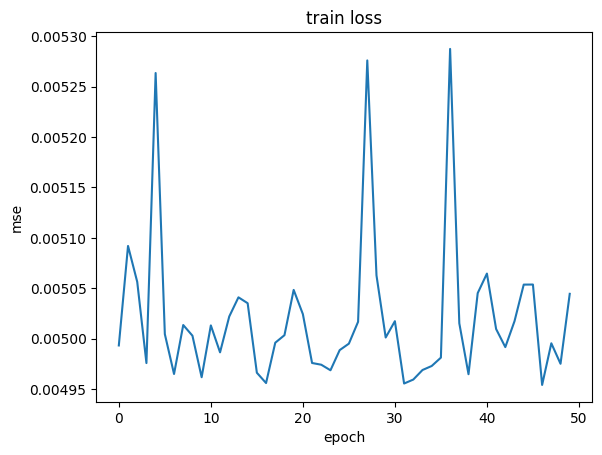

In [27]:
plt.plot(train_loss_history[-50:])
plt.title("train loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

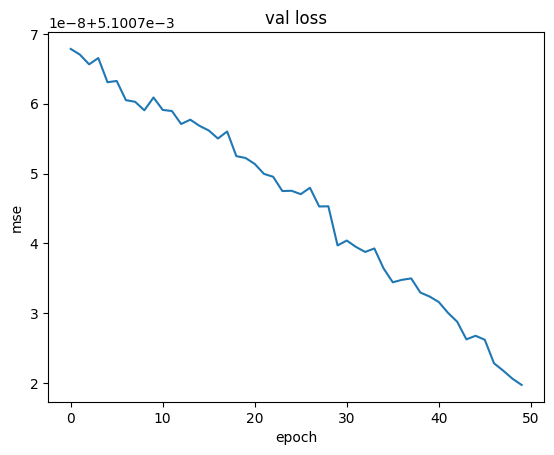

In [26]:
plt.plot(val_loss_history[-50:])
plt.title("val loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

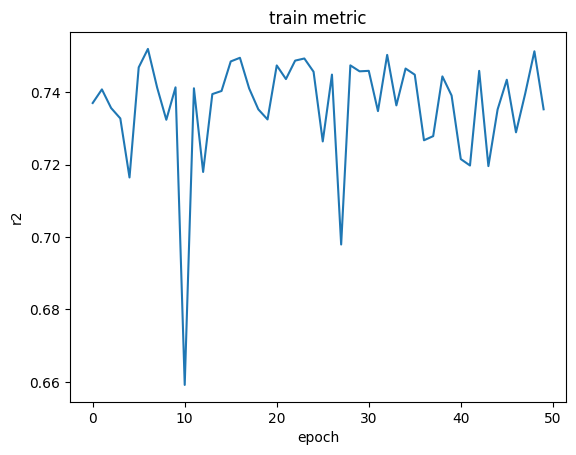

In [25]:
plt.plot(train_metric_history[-50:])
plt.title("train metric")
plt.xlabel("epoch")
plt.ylabel("r2")
plt.show()

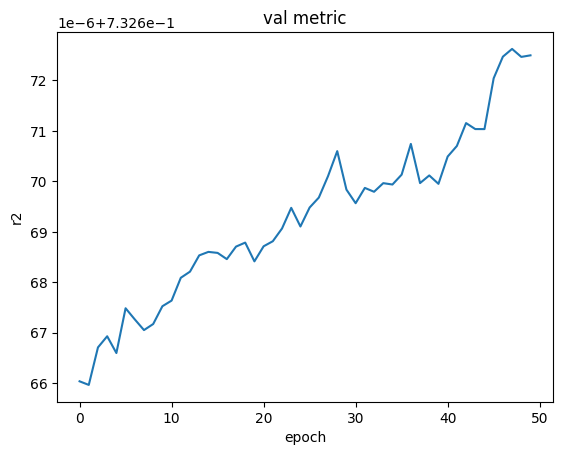

In [24]:
plt.plot(val_metric_history[-50:])
plt.title("val metric")
plt.xlabel("epoch")
plt.ylabel("r2")
plt.show()